## Multi-label Disease Classification of Chest X-Ray Images
#### UC San Diego Machine Learning Engineering Bootcamp
Tung Nguyen

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from skmultilearn.model_selection.iterative_stratification import iterative_train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
random_state = 2022

train_size = 0.8
val_size = 0.2
test_size = 0.25

### Data Wrangling
---

In [3]:
# Read CSV
df = pd.read_csv('/Users/tungnguyen/Documents/capstone/Data_Entry_2017.csv')

# Drop unnecessary columns
df.drop(['OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'], axis=1, inplace=True)
print('Original DataFrame shape = {}'.format(df.shape))

# Some patients have age >200 - impute with mean of age from rows with the same Patient ID
err = df[df['Patient Age'] > 100]
df_dropped = df[df['Patient Age'] < 100]

for ind, row in err.iterrows():
    pid = row['Patient ID']
    avg = df_dropped[df_dropped['Patient ID'] == pid]['Patient Age'].mean()
    df.iat[ind, 4] = int(avg) if not(np.isnan(avg)) else -1

# There are ~3 patients with just a single datapoint - drop these 3 data points
df = df[df['Patient Age'] != -1]
df.reset_index(inplace=True)
print('Wrangled DataFrame shape = {}'.format(df.shape))

# Replace "No Finding" labels with blank
df['Finding Labels'] = df['Finding Labels'].replace(to_replace='No Finding', value='')

# Binarize
mlb = MultiLabelBinarizer()
lbl = mlb.fit_transform(df['Finding Labels'].str.split("|"))
df_mlb = pd.DataFrame(lbl, columns=mlb.classes_, dtype=np.float32)

# Drop 'No Finding' column
df_mlb.drop('', axis=1, inplace=True)

# Merge with main df
df = df.join(df_mlb)
print('Binarized DataFrame shape = {}'.format(df.shape))

# Get list of all labels
labels = [x for x in mlb.classes_ if x != '']
print()
print(labels)

Original DataFrame shape = (112120, 7)
Wrangled DataFrame shape = (112117, 8)
Binarized DataFrame shape = (112117, 22)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [4]:
df

,index,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,Atelectasis,Cardiomegaly,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,00000002_000.png,,0,2,81,M,PA,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,00000003_000.png,Hernia,0,3,81,F,PA,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112112,112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
112113,112116,00030802_000.png,,0,30802,29,M,PA,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112114,112117,00030803_000.png,,0,30803,42,F,PA,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112115,112118,00030804_000.png,,0,30804,30,F,PA,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Iterative Train/Test Split with sklearn
---

In [5]:
tab_data_cols = ['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position']
X = df[tab_data_cols]
y = df[labels]

X_train, y_train, X_test, y_test = iterative_train_test_split(
    X.to_numpy(), 
    y.to_numpy(), 
    test_size=test_size,
)

In [6]:
# Convert matrices to DataFrames for Keras' flow_from_dataframe
train_df = pd.DataFrame(
    np.hstack((X_train, y_train)),
    columns=[item for sublist in [tab_data_cols, labels] for item in sublist]
)

test_df = pd.DataFrame(
    np.hstack((X_test, y_test)),
    columns=[item for sublist in [tab_data_cols, labels] for item in sublist]
)

# Convert labels to float32 for Keras training
for col in train_df:
    if col in labels:
        train_df[col] = train_df[col].astype(np.float32)
        
for col in test_df:
    if col in labels:
        test_df[col] = test_df[col].astype(np.float32)

In [7]:
with pd.option_context('max_columns', None):
    display(train_df.sample(3))

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
24569,00008064_007.png,Infiltration,7,8064,69,M,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
80726,00029068_000.png,,0,29068,33,F,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14993,00005020_001.png,,1,5020,58,F,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
with pd.option_context('max_columns', None):
    display(test_df.sample(3))

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
25687,00027423_000.png,,0,27423,45,M,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22599,00022848_000.png,,0,22848,46,F,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
385,00000372_015.png,Effusion|Nodule,15,372,82,M,PA,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [9]:
def plot_df_freq(df, labels, offset=500, title='Frequency of Positive Labels'):
    df_pos = df[labels].sum()

    ax = df_pos.plot(kind='bar', figsize=(15, 7), rot=20);
    ax.set_title(title, fontsize=16);
    ax.set_xlabel('Labels', fontsize=12);
    ax.set_ylabel('Frequency', fontsize=12);

    for i, val in enumerate(df_pos.values):
        ax.text(i, val + offset, int(val), ha = 'center')

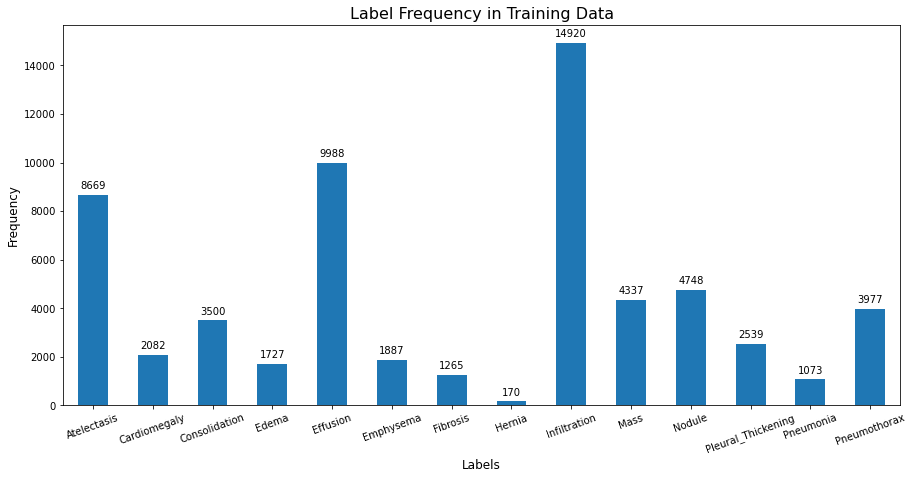

In [10]:
plot_df_freq(train_df, labels, offset=250, title='Label Frequency in Training Data')

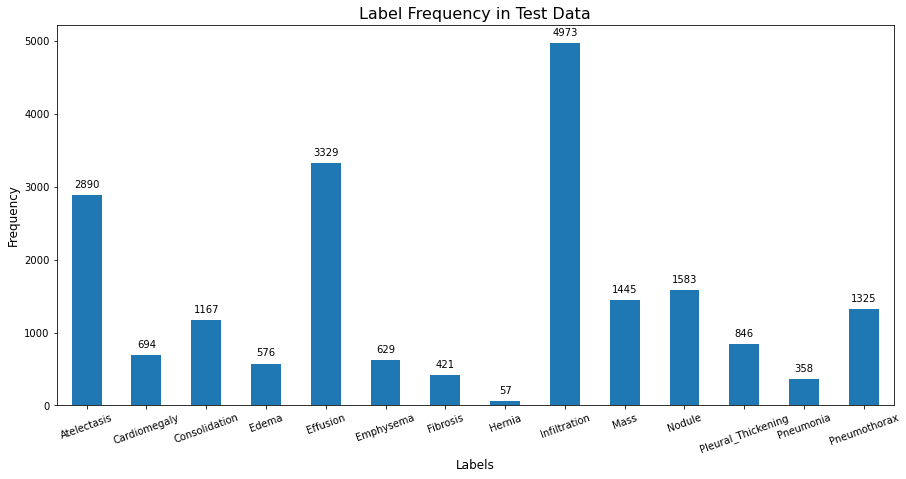

In [11]:
plot_df_freq(test_df, labels, offset=100, title='Label Frequency in Test Data')

### Data Sampling
---

In [13]:
# class weights for weighed loss
pos = np.array([])
neg = np.array([])
for d in weights:
    pos = np.append(pos, d[1] / sum(d.values()))
    neg = np.append(neg, d[0] / sum(d.values())) 

print(pos)
print(neg)

[0.8969044  0.97523993 0.95837644 0.97946175 0.88121826 0.97755896
 0.98495606 0.99797828 0.82256472 0.94842247 0.94353467 0.96980508
 0.98723941 0.95270375]
[0.1030956  0.02476007 0.04162356 0.02053825 0.11878174 0.02244104
 0.01504394 0.00202172 0.17743528 0.05157753 0.05646533 0.03019492
 0.01276059 0.04729625]


In [12]:
weights = []
for i, lbl in enumerate(labels):
    weights.append(dict(enumerate(compute_class_weight(class_weight='balanced', classes=[0., 1.], y=train_df[lbl]))))

weights

[{0: 0.5574730170516322, 1: 4.849867343407544},
 {0: 0.5126943479056155, 1: 20.193804034582133},
 {0: 0.5217156613349547, 1: 12.012428571428572},
 {0: 0.5104844584749879, 1: 24.344817602779386},
 {0: 0.567396321137937, 1: 4.209401281537845},
 {0: 0.5114781021897811, 1: 22.28060413354531},
 {0: 0.5076368597715583, 1: 33.23596837944664},
 {0: 0.5010129056091137, 1: 247.31470588235294},
 {0: 0.6078549019040872, 1: 2.8179289544235924},
 {0: 0.527191222570533, 1: 9.6941434171086},
 {0: 0.5299222324455816, 1: 8.854991575400168},
 {0: 0.5155675185167018, 1: 16.559078377313902},
 {0: 0.5064627653166935, 1: 39.183131407269336},
 {0: 0.5248221195855698, 1: 10.571662056826753}]

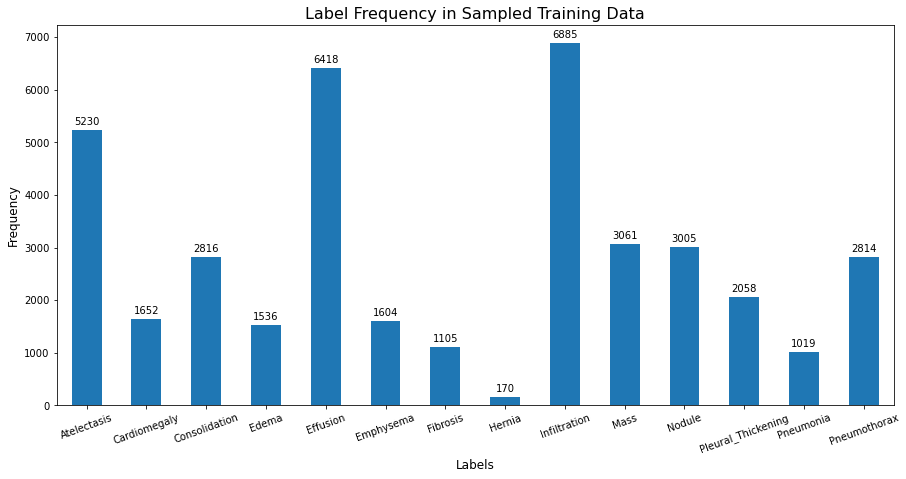

In [84]:
sample_weights = compute_sample_weight(class_weight=weights, y=train_df[labels])
train_df['sample_weights'] = sample_weights

sampled_train_df = train_df.sample(
    20000, 
    weights=sample_weights,
    random_state=random_state
)

plot_df_freq(sampled_train_df, labels, offset=100, title='Label Frequency in Sampled Training Data')

In [15]:
with pd.option_context('max_columns', None):
    display(sampled_train_df)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,sample_weights
52893,00017325_014.png,Cardiomegaly|Edema|Effusion|Infiltration|Mass|...,14,17325,66,M,AP,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,3.859499e+05
72036,00025262_000.png,Atelectasis|Consolidation|Edema|Effusion|Infil...,0,25262,45,M,AP,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,3.279822e+07
63164,00020622_003.png,Atelectasis|Consolidation|Effusion|Fibrosis|In...,3,20622,74,F,PA,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.172360e+07
58004,00018949_006.png,Cardiomegaly|Consolidation|Edema|Effusion|Mass...,6,18949,7,M,AP,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,4.140207e+05
61059,00019924_031.png,Atelectasis|Cardiomegaly|Consolidation|Edema|E...,31,19924,56,F,AP,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,5.198854e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5761,00001946_001.png,Consolidation,1,1946,12,M,AP,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.010487e-03
77811,00027685_006.png,Atelectasis|Nodule,6,27685,61,F,PA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.900736e-02
69860,00023138_003.png,Infiltration|Pneumothorax,3,23138,40,M,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.220959e-02
13362,00004526_016.png,Cardiomegaly,16,4526,35,F,PA,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.149908e-03


#### Notes
- compute_class_weight does not work for multilabel problems
- compute_sample_weight supports multilabel problems, but requires a nested dictionary of class weights, which there currently exists no method to calculate.
- Dictionary format {{0: 100, 1: 20}, {0: 100, 1: 20}, {0: 100, 1: 20}, ... to _n_ classes}
- https://stackoverflow.com/questions/48485870/multi-label-classification-with-class-weights-in-keras
- https://stackoverflow.com/questions/48485870/multi-label-classification-with-class-weights-in-keras

### Data Generators
---

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
def datagen_from_df(train_df, test_df, x_col, y_cols, data_path, sample_norm=True, target_size=(256, 256), 
                    val_split=0.2, batch_size=64, color_mode='rgb', weight_col=None):

    datagen = ImageDataGenerator(
        samplewise_center=sample_norm,
        samplewise_std_normalization=sample_norm, 
        horizontal_flip = True, 
        vertical_flip = False, 
        height_shift_range= 0.05, 
        width_shift_range=0.1, 
        rotation_range=5, 
        shear_range = 0.1,
        fill_mode = 'reflect',
        zoom_range=0.15,
        validation_split=val_split
    )

    train_generator = datagen.flow_from_dataframe(
        train_df,   
        data_path,
        shuffle=True,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        weight_col=weight_col,
        subset='training'
    )

    validation_generator = datagen.flow_from_dataframe(
        train_df,
        data_path,
        shuffle=False,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        subset='validation'
    )

    test_generator = datagen.flow_from_dataframe(
        test_df,
        data_path,
        shuffle=False,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols
    )
    
    return train_generator, validation_generator, test_generator

In [18]:
data_dir = '/Users/tungnguyen/Documents/capstone/data/'

### VGG16 Trade Studies
---

In [19]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc, precision_recall_curve, multilabel_confusion_matrix

In [75]:
def plot_losses(model_history):
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    ax.plot(model_history.history['val_loss'], 'r-o')
    ax.plot(model_history.history['loss'], 'b-o')
    ax.set_title('Training vs. Validation Loss', fontsize=18, fontweight='bold')
    ax.legend(['Validation Loss', 'Training Loss'])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

def plot_roc_auc(y_pred, test_df, labels, model_name):
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    for i, lbl in enumerate(labels):
        fpr, tpr, thresholds = roc_curve(test_df[lbl].to_numpy(), y_pred[:, i])
        ax.plot(fpr, tpr, label = '%s (AUC: %0.2f)'  % (lbl, auc(fpr, tpr)))
        print("AUC = %0.4f for %s" % (auc(fpr, tpr), lbl))

    ax.legend()
    ax.set_title('ROC Curves for Test Data - ' + model_name, fontsize=18, fontweight='bold');
    ax.set_xlabel('False Positive Rate (FPR)');
    ax.set_ylabel('True Positive Rate (TPR)');

def plot_precision_recall_auc(y_pred, test_df, labels, model_name):
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    for i, lbl in enumerate(labels):
        pr, rc, thresholds = precision_recall_curve(test_df[lbl].to_numpy(), y_pred[:, i])
        ax.plot(rc, pr, label = '%s (AUC: %0.4f)'  % (lbl, auc(rc, pr)))
        print("AUC = %0.4f for %s" % (auc(rc, pr), lbl))

    ax.legend()
    ax.set_title('Precision-Recall Curves for Test Data - ' + model_name, fontsize=18, fontweight='bold');
    ax.set_xlabel('Recall');
    ax.set_ylabel('Precision');

#### Strategy for Runs
- All following runs use 20,0000 data points from sampled_train_df
- All use VGG16 as the base model


| Hyperparameter | 1 | 2 | 3 | 4 | 5 | 6 |
|:------:|:------:|:------:|:------:|:------:|:------:|:------:|
|Sample Normalization    |True    |True    |True     |False    |True     |False    |
|Sample Weights          |False   |True    |False    |False    |False    |False    |
|Loss Function           |Default |Default |Weighted |Weighted |Weighted |Weighted |
|Data Augmentation       |True    |True    |True     |True     |False    |False    |
|Notes                   |Base|Sample Weights|Weighted Loss|Normalization Test|Augmentation Test|Interaction Test|

NOTE: Default loss function is Keras' binary cross entropy

In [21]:
base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3)
)


early = EarlyStopping(
    monitor="val_loss",
    mode="min", 
    patience=10
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=5, 
    min_lr=0.001
)

Metal device set to: Apple M1 Max


2022-01-10 20:56:00.423778: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-10 20:56:00.423907: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### 1. Base Model
- binary cross entropy loss
- samplewise normalization + randomized augmentation
- no sample or class weights

In [22]:
train_generator, valid_generator, test_generator = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, 
    sample_norm=True, target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb'
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [23]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)       2

In [24]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [25]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/vgg16-base-study.h5'

base_chkpt = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [26]:
%%time
base_history = model.fit(
    train_generator, 
    validation_data=valid_generator,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [base_chkpt, early, reduce_lr]
)

2022-01-10 20:56:02.222153: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/40


2022-01-10 20:56:02.443918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 0.3536 - accuracy: 0.1241

2022-01-10 21:02:10.257947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.54063, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/vgg16-base-study.h5
250/250 [==============================] - 435s 2s/step - loss: 0.3536 - accuracy: 0.1241 - val_loss: 0.5406 - val_accuracy: 0.0458 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 0.3240 - accuracy: 0.1532
Epoch 00002: val_loss improved from 0.54063 to 0.51686, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/vgg16-base-study.h5
250/250 [==============================] - 433s 2s/step - loss: 0.3240 - accuracy: 0.1532 - val_loss: 0.5169 - val_accuracy: 0.0808 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 0.3215 - accuracy: 0.1666
Epoch 00003: val_loss improved from 0.51686 to 0.51180, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/vgg16-base-study.h5
250/250 [==============================] - 432s 2s/step - loss: 0.3215 - accuracy: 0.1666 - val_loss: 0.

In [27]:
y_pred_base = model.predict(test_generator, batch_size=64, verbose=True)

2022-01-11 01:44:03.889516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 459s 1s/step


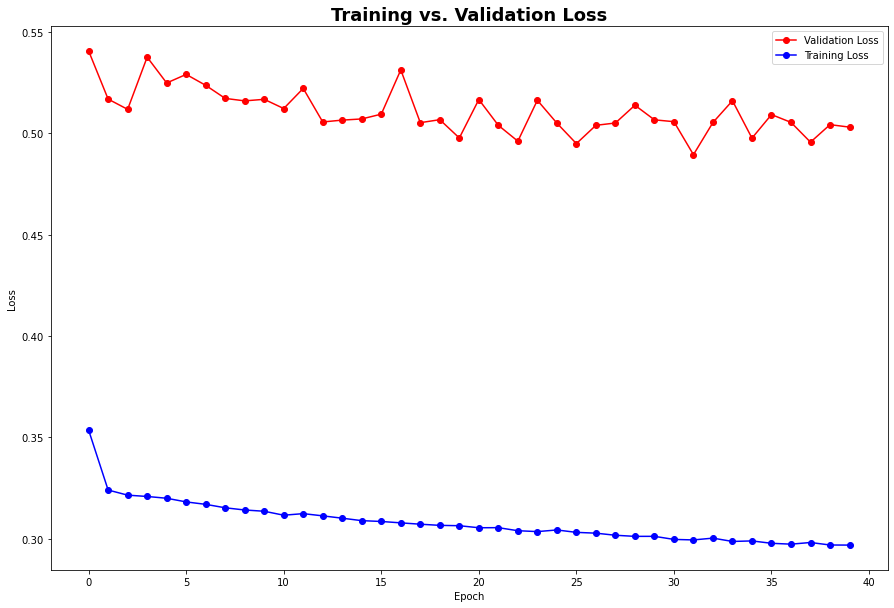

In [28]:
plot_losses(base_history)

AUC = 0.7432 for Atelectasis
AUC = 0.8630 for Cardiomegaly
AUC = 0.7320 for Consolidation
AUC = 0.8286 for Edema
AUC = 0.8093 for Effusion
AUC = 0.7152 for Emphysema
AUC = 0.6097 for Fibrosis
AUC = 0.7207 for Hernia
AUC = 0.6575 for Infiltration
AUC = 0.5997 for Mass
AUC = 0.5772 for Nodule
AUC = 0.6082 for Pleural_Thickening
AUC = 0.5165 for Pneumonia
AUC = 0.7330 for Pneumothorax


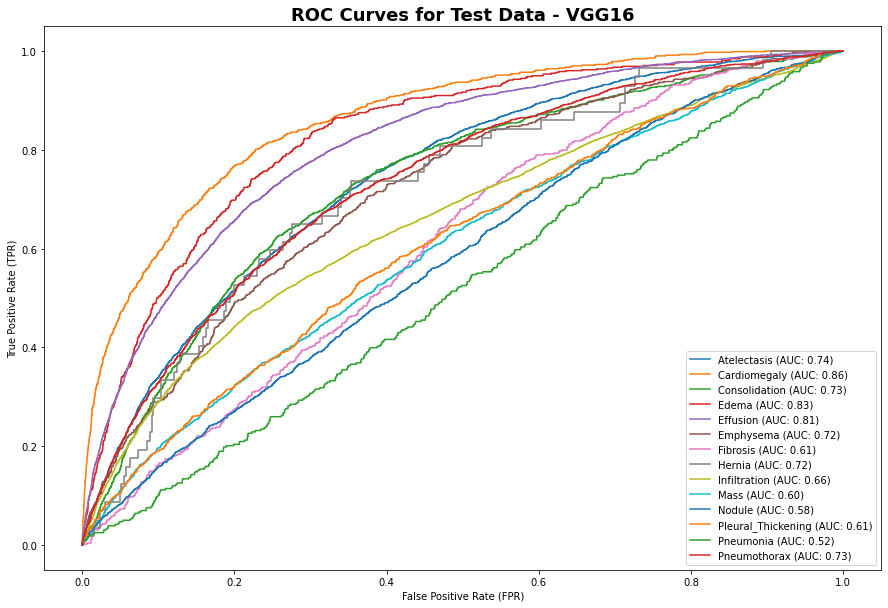

In [76]:
plot_roc_auc(y_pred_base, test_df, labels, model_name='VGG16')

AUC = 0.2447 for Atelectasis
AUC = 0.2241 for Cardiomegaly
AUC = 0.0988 for Consolidation
AUC = 0.0990 for Edema
AUC = 0.3866 for Effusion
AUC = 0.0572 for Emphysema
AUC = 0.0200 for Fibrosis
AUC = 0.0046 for Hernia
AUC = 0.3142 for Infiltration
AUC = 0.0781 for Mass
AUC = 0.0737 for Nodule
AUC = 0.0475 for Pleural_Thickening
AUC = 0.0140 for Pneumonia
AUC = 0.1243 for Pneumothorax


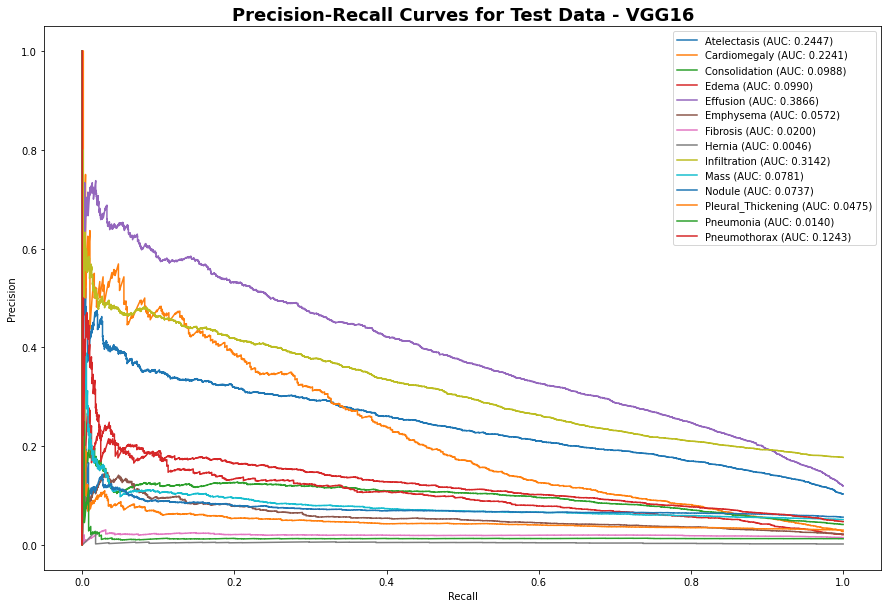

In [77]:
plot_precision_recall_auc(y_pred_base, test_df, labels, model_name='VGG16')

#### 2. Sample Weights
- binary cross entropy loss 
- samplewise normalization + data randomized augmentation
- sample weights from sklearn's compute_sample_weights on sampled_train_df

In [43]:
train_generator, valid_generator, test_generator = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, 
    sample_norm=True, target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', weight_col='sample_weights'
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [82]:
sampled_train_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,Atelectasis,Cardiomegaly,Consolidation,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,sample_weights
52893,00017325_014.png,Cardiomegaly|Edema|Effusion|Infiltration|Mass|...,14,17325,66,M,AP,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,3.859499e+05
72036,00025262_000.png,Atelectasis|Consolidation|Edema|Effusion|Infil...,0,25262,45,M,AP,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,3.279822e+07
63164,00020622_003.png,Atelectasis|Consolidation|Effusion|Fibrosis|In...,3,20622,74,F,PA,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.172360e+07
58004,00018949_006.png,Cardiomegaly|Consolidation|Edema|Effusion|Mass...,6,18949,7,M,AP,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,4.140207e+05
61059,00019924_031.png,Atelectasis|Cardiomegaly|Consolidation|Edema|E...,31,19924,56,F,AP,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,5.198854e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5761,00001946_001.png,Consolidation,1,1946,12,M,AP,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.010487e-03
77811,00027685_006.png,Atelectasis|Nodule,6,27685,61,F,PA,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.900736e-02
69860,00023138_003.png,Infiltration|Pneumothorax,3,23138,40,M,AP,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.220959e-02
13362,00004526_016.png,Cardiomegaly,16,4526,35,F,PA,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.149908e-03


In [44]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [45]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [46]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/vgg16-sample-weights.h5'

sample_weights_chkpt = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [47]:
%%time
sample_weights_history = model.fit(
    train_generator, 
    validation_data=valid_generator,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [sample_weights_chkpt, early, reduce_lr]
)

Epoch 1/40


2022-01-11 06:14:53.118824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 0.0176 - accuracy: 0.1741

2022-01-11 06:21:00.309663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.46810, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/vgg16-sample-weights.h5
250/250 [==============================] - 435s 2s/step - loss: 0.0176 - accuracy: 0.1741 - val_loss: 0.4681 - val_accuracy: 0.1775 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.1981
Epoch 00002: val_loss improved from 0.46810 to 0.46328, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/vgg16-sample-weights.h5
250/250 [==============================] - 438s 2s/step - loss: 0.0170 - accuracy: 0.1981 - val_loss: 0.4633 - val_accuracy: 0.0985 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 0.0171 - accuracy: 0.1854
Epoch 00003: val_loss did not improve from 0.46328
250/250 [==============================] - 435s 2s/step - loss: 0.0171 - accuracy: 0.1854 - val_loss: 0.4853 - val_accuracy: 0.1675 - lr: 0.0010
Epoch 4/40
250/250 [===================

In [48]:
y_pred_sample_weights = model.predict(test_generator, batch_size=64, verbose=True)

2022-01-11 07:41:49.622288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 461s 1s/step


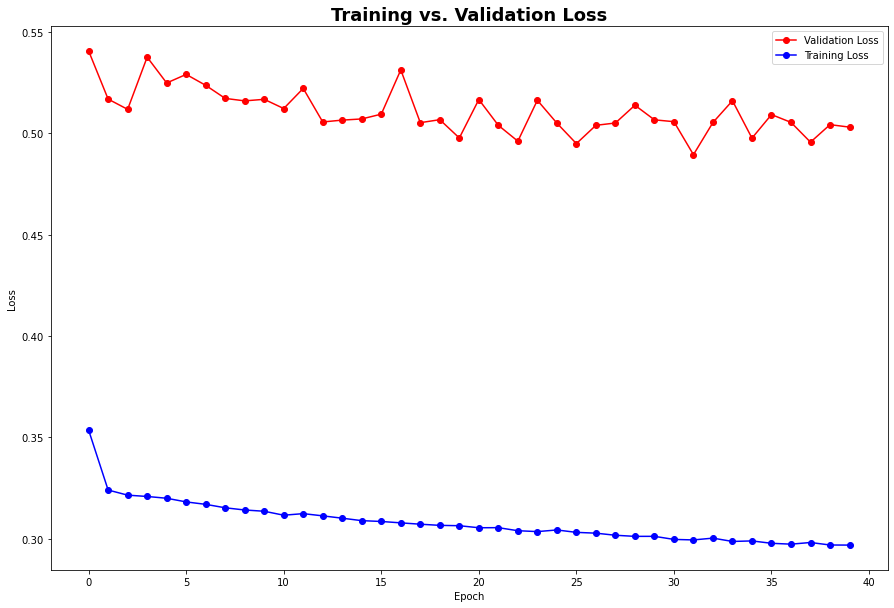

In [49]:
plot_losses(base_history)

AUC = 0.7029 for Atelectasis
AUC = 0.8355 for Cardiomegaly
AUC = 0.7074 for Consolidation
AUC = 0.8142 for Edema
AUC = 0.7774 for Effusion
AUC = 0.5999 for Emphysema
AUC = 0.5650 for Fibrosis
AUC = 0.6826 for Hernia
AUC = 0.6688 for Infiltration
AUC = 0.5484 for Mass
AUC = 0.5524 for Nodule
AUC = 0.5284 for Pleural_Thickening
AUC = 0.5448 for Pneumonia
AUC = 0.6596 for Pneumothorax


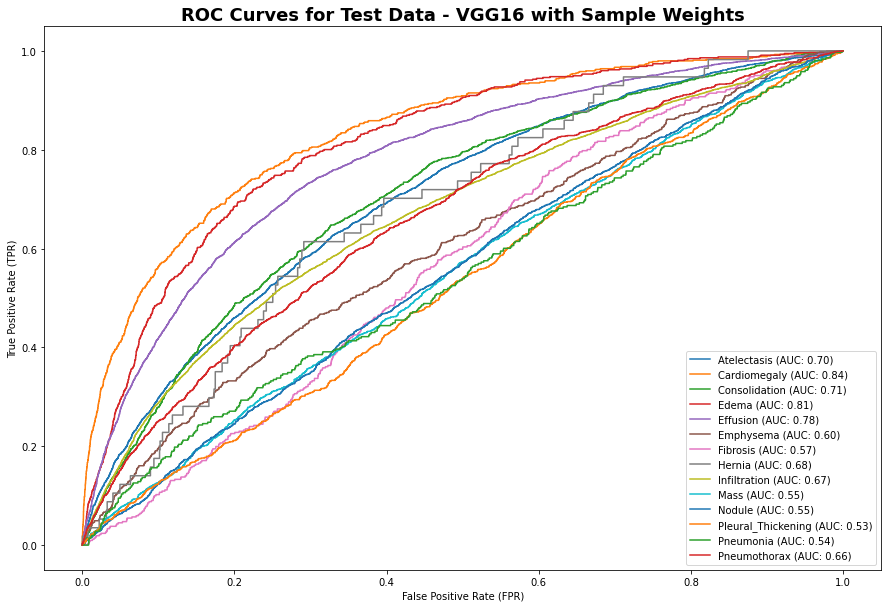

In [78]:
plot_roc_auc(y_pred_sample_weights, test_df, labels, model_name='VGG16 with Sample Weights')

AUC = 0.2204 for Atelectasis
AUC = 0.2022 for Cardiomegaly
AUC = 0.0899 for Consolidation
AUC = 0.0895 for Edema
AUC = 0.3325 for Effusion
AUC = 0.0371 for Emphysema
AUC = 0.0168 for Fibrosis
AUC = 0.0043 for Hernia
AUC = 0.3139 for Infiltration
AUC = 0.0606 for Mass
AUC = 0.0650 for Nodule
AUC = 0.0334 for Pleural_Thickening
AUC = 0.0159 for Pneumonia
AUC = 0.0925 for Pneumothorax


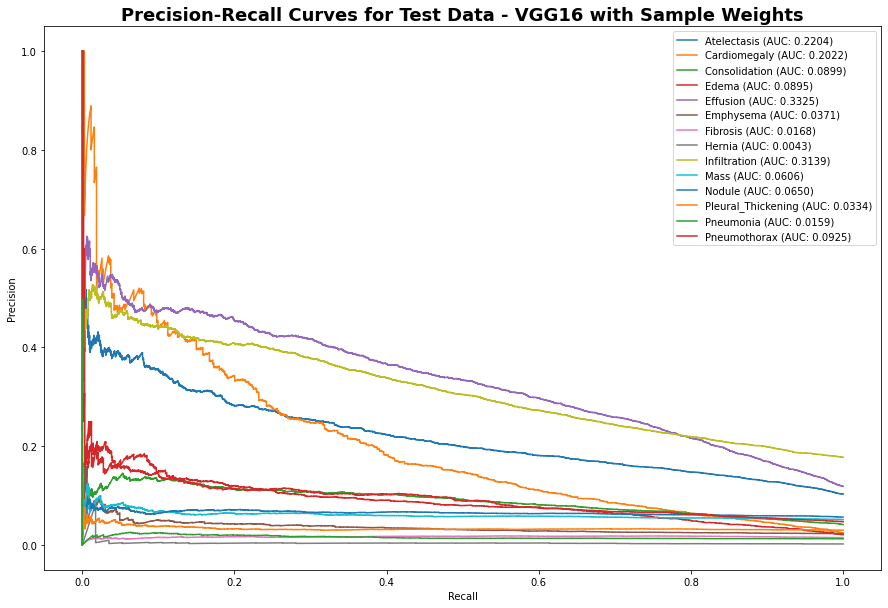

In [79]:
plot_precision_recall_auc(y_pred_sample_weights, test_df, labels, model_name='VGG16 with Sample Weights')

#### Custom Weighted Loss

In [66]:
from tensorflow.keras import backend as K

def get_weighted_loss(pos, neg, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        loss = 0.0
        for i in range(len(pos)):
            loss += -1 * K.mean(pos * y_true * K.log(y_pred + epsilon) + 
                          (1 - y_true) * neg * K.log(1 - y_pred + epsilon))      
        return loss
    return weighted_loss

#### 3. Custom Loss
- weighted binary cross entropy loss - positive/negative weighted by their class_weight (from sklearn's compute_class_weight)
- samplewise normalization + data randomized augmentation
- no sample or class weights

In [53]:
train_generator, valid_generator, test_generator = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, 
    sample_norm=True, target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb'
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [54]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [68]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg),
    metrics=['accuracy']
)

In [69]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/vgg16-weighted-loss.h5'

weighted_loss_chkpt = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [70]:
%%time
weighted_loss_history = model.fit(
    train_generator, 
    validation_data=valid_generator,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [weighted_loss_chkpt, early, reduce_lr]
)

Epoch 1/40


2022-01-11 07:59:31.790790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.1639 - accuracy: 0.1657

2022-01-11 08:05:41.635617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.45221, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/vgg16-weighted-loss.h5
250/250 [==============================] - 436s 2s/step - loss: 1.1639 - accuracy: 0.1657 - val_loss: 1.4522 - val_accuracy: 0.1950 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 1.1324 - accuracy: 0.1809
Epoch 00002: val_loss did not improve from 1.45221
250/250 [==============================] - 432s 2s/step - loss: 1.1324 - accuracy: 0.1809 - val_loss: 1.4655 - val_accuracy: 0.1703 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 1.1265 - accuracy: 0.1879
Epoch 00003: val_loss did not improve from 1.45221
250/250 [==============================] - 432s 2s/step - loss: 1.1265 - accuracy: 0.1879 - val_loss: 1.4963 - val_accuracy: 0.2043 - lr: 0.0010
Epoch 4/40
250/250 [==============================] - ETA: 0s - loss: 1.1169 - accuracy: 0.1880
Epoch 00004: val_loss did not improv

In [71]:
y_pred_weighted_loss = model.predict(test_generator, batch_size=64, verbose=True)

2022-01-11 10:17:22.480934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 462s 1s/step


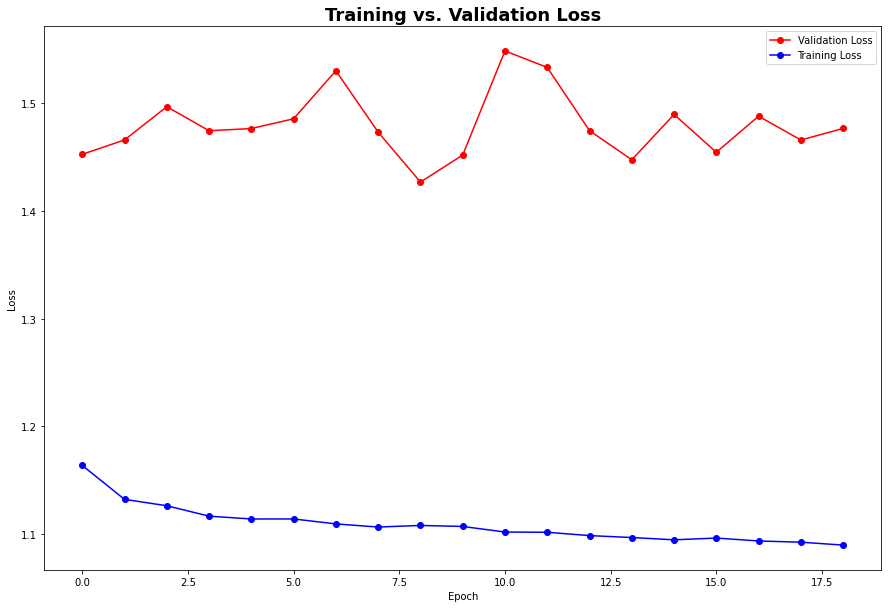

In [72]:
plot_losses(weighted_loss_history)

AUC = 0.7417 for Atelectasis
AUC = 0.8525 for Cardiomegaly
AUC = 0.7240 for Consolidation
AUC = 0.8508 for Edema
AUC = 0.8226 for Effusion
AUC = 0.6828 for Emphysema
AUC = 0.6194 for Fibrosis
AUC = 0.7343 for Hernia
AUC = 0.6549 for Infiltration
AUC = 0.6292 for Mass
AUC = 0.5846 for Nodule
AUC = 0.6055 for Pleural_Thickening
AUC = 0.4974 for Pneumonia
AUC = 0.7316 for Pneumothorax


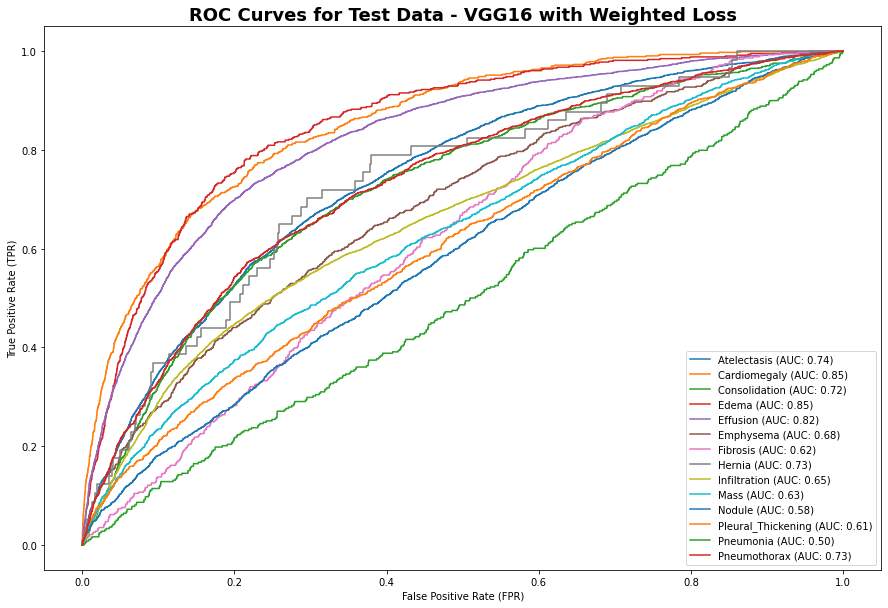

In [80]:
plot_roc_auc(y_pred_weighted_loss, test_df, labels, model_name='VGG16 with Weighted Loss')

AUC = 0.2527 for Atelectasis
AUC = 0.1994 for Cardiomegaly
AUC = 0.0980 for Consolidation
AUC = 0.1164 for Edema
AUC = 0.4176 for Effusion
AUC = 0.0526 for Emphysema
AUC = 0.0206 for Fibrosis
AUC = 0.0064 for Hernia
AUC = 0.3031 for Infiltration
AUC = 0.0942 for Mass
AUC = 0.0825 for Nodule
AUC = 0.0533 for Pleural_Thickening
AUC = 0.0130 for Pneumonia
AUC = 0.1245 for Pneumothorax


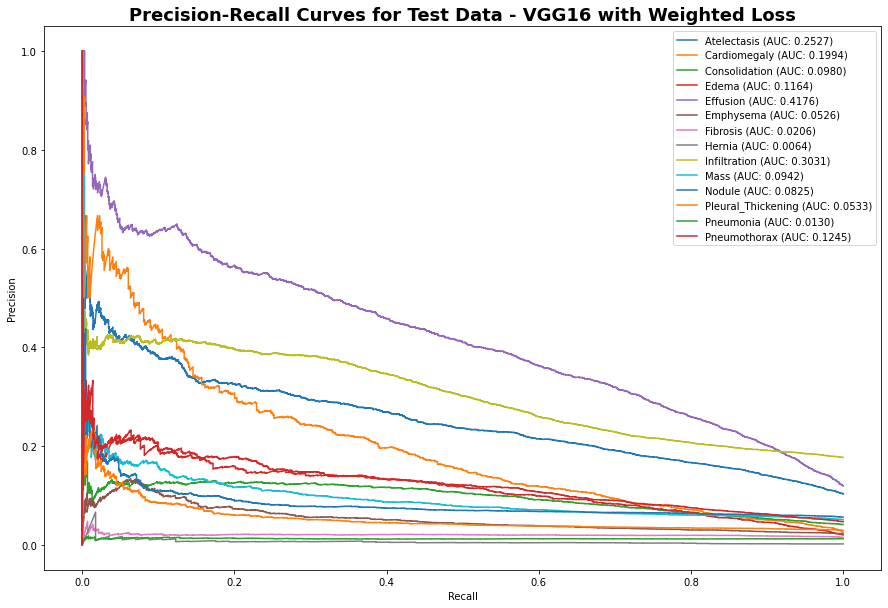

In [81]:
plot_precision_recall_auc(y_pred_weighted_loss, test_df, labels, model_name='VGG16 with Weighted Loss')

#### 4. Custom Loss (Samplewise Normalization Test)
- weighted binary cross entropy loss - positive/negative weighted by their class_weight (from sklearn's compute_class_weight)
- data randomized augmentation, but <u>no</u> samplewise normalization
- no sample or class weights

In [85]:
train_generator, valid_generator, test_generator = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, 
    sample_norm=True, target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb'
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [86]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [87]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg),
    metrics=['accuracy']
)

In [88]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/vgg16-weighted-loss-woNorm.h5'

weighted_loss_woNorm_chkpt = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [89]:
%%time
weighted_loss_woNorm_history = model.fit(
    train_generator, 
    validation_data=valid_generator,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [weighted_loss_woNorm_chkpt, early, reduce_lr]
)

Epoch 1/40


2022-01-11 12:38:55.258580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.1344 - accuracy: 0.1873

2022-01-11 12:45:05.083036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.48818, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/vgg16-weighted-loss-woNorm.h5
250/250 [==============================] - 438s 2s/step - loss: 1.1344 - accuracy: 0.1873 - val_loss: 1.4882 - val_accuracy: 0.2335 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 1.1023 - accuracy: 0.2043
Epoch 00002: val_loss improved from 1.48818 to 1.47640, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/vgg16-weighted-loss-woNorm.h5
250/250 [==============================] - 434s 2s/step - loss: 1.1023 - accuracy: 0.2043 - val_loss: 1.4764 - val_accuracy: 0.1995 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 1.0969 - accuracy: 0.2108
Epoch 00003: val_loss did not improve from 1.47640
250/250 [==============================] - 431s 2s/step - loss: 1.0969 - accuracy: 0.2108 - val_loss: 1.5146 - val_accuracy: 0.2390 - lr: 0.0010
Epoch 4/40
250/250 [=======

In [90]:
y_pred_weighted_loss_woNorm = model.predict(test_generator, batch_size=64, verbose=True)

2022-01-11 15:02:56.672537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 457s 1s/step


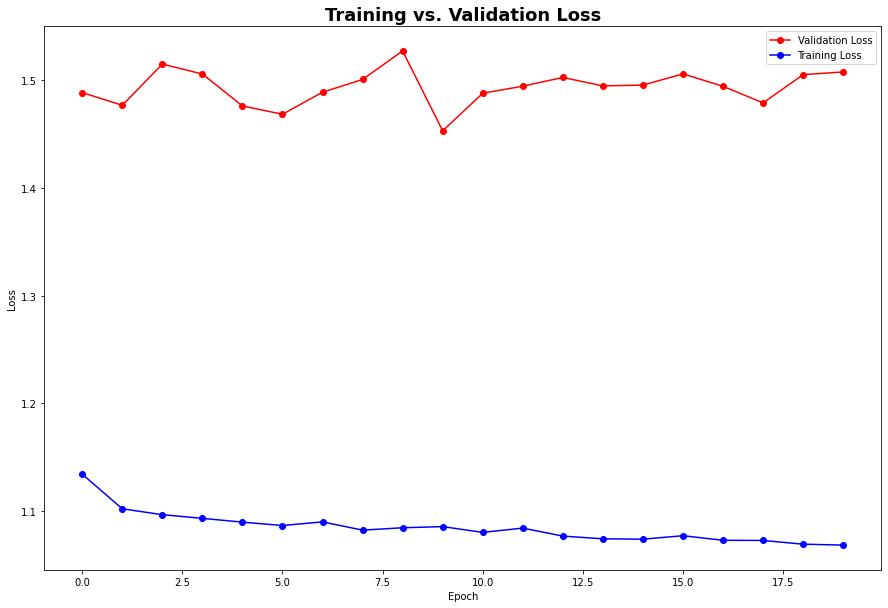

In [91]:
plot_losses(weighted_loss_woNorm_history)

AUC = 0.7377 for Atelectasis
AUC = 0.8775 for Cardiomegaly
AUC = 0.7278 for Consolidation
AUC = 0.8322 for Edema
AUC = 0.8345 for Effusion
AUC = 0.6959 for Emphysema
AUC = 0.6334 for Fibrosis
AUC = 0.7181 for Hernia
AUC = 0.6148 for Infiltration
AUC = 0.6616 for Mass
AUC = 0.5957 for Nodule
AUC = 0.6474 for Pleural_Thickening
AUC = 0.5362 for Pneumonia
AUC = 0.7355 for Pneumothorax


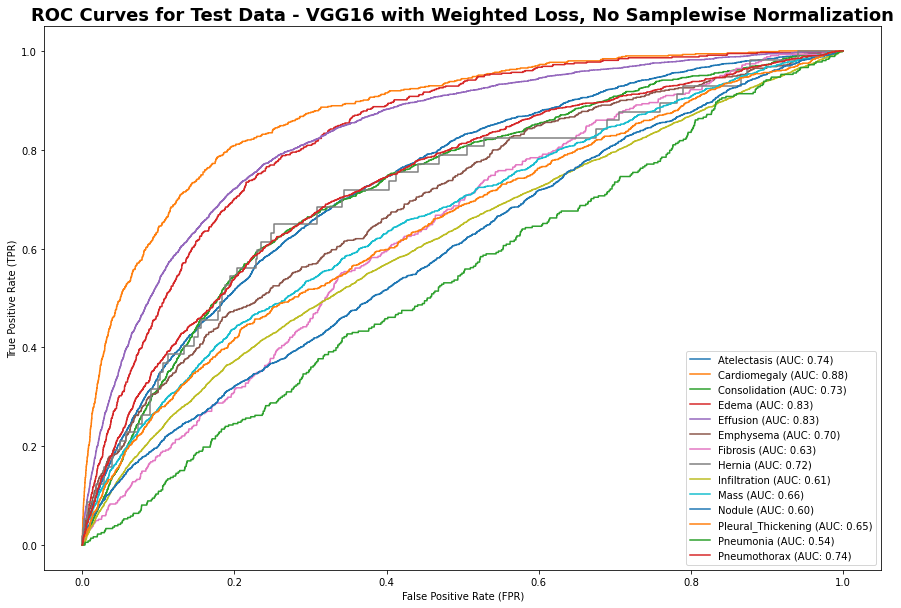

In [92]:
plot_roc_auc(y_pred_weighted_loss_woNorm, test_df, labels, model_name='VGG16 with Weighted Loss, No Samplewise Normalization')

AUC = 0.2495 for Atelectasis
AUC = 0.2408 for Cardiomegaly
AUC = 0.0988 for Consolidation
AUC = 0.0939 for Edema
AUC = 0.4320 for Effusion
AUC = 0.0667 for Emphysema
AUC = 0.0239 for Fibrosis
AUC = 0.0084 for Hernia
AUC = 0.2657 for Infiltration
AUC = 0.1150 for Mass
AUC = 0.0930 for Nodule
AUC = 0.0630 for Pleural_Thickening
AUC = 0.0139 for Pneumonia
AUC = 0.1335 for Pneumothorax


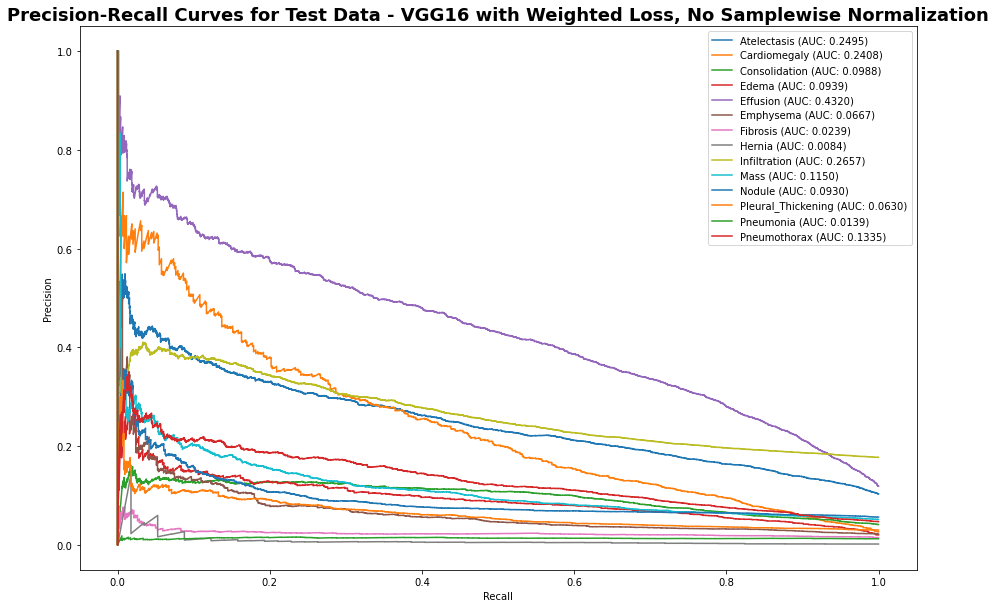

In [93]:
plot_precision_recall_auc(y_pred_weighted_loss_woNorm, test_df, labels, model_name='VGG16 with Weighted Loss, No Samplewise Normalization')

#### 5. Custom Loss (Data Augmentation Test)
- weighted binary cross entropy loss - positive/negative weighted by their class_weight (from sklearn's compute_class_weight)
- samplewise normalization, but <u>no</u> data randomized augmentation
- no sample or class weights

In [94]:
train_generator, valid_generator, test_generator = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, 
    sample_norm=True, target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb'
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [95]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [96]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg),
    metrics=['accuracy']
)

In [97]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/vgg16-weighted-loss-woAugment.h5'

weighted_loss_woAugment_chkpt = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [98]:
%%time
weighted_loss_woAugment_history = model.fit(
    train_generator, 
    validation_data=valid_generator,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [weighted_loss_woAugment_chkpt, early, reduce_lr]
)

Epoch 1/40


2022-01-11 15:10:36.781285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.1234 - accuracy: 0.2017

2022-01-11 15:16:45.597008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.52272, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/vgg16-weighted-loss-woAugment.h5
250/250 [==============================] - 435s 2s/step - loss: 1.1234 - accuracy: 0.2017 - val_loss: 1.5227 - val_accuracy: 0.2145 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 1.0851 - accuracy: 0.2186
Epoch 00002: val_loss improved from 1.52272 to 1.47294, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/vgg16-weighted-loss-woAugment.h5
250/250 [==============================] - 432s 2s/step - loss: 1.0851 - accuracy: 0.2186 - val_loss: 1.4729 - val_accuracy: 0.1815 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 1.0838 - accuracy: 0.2124
Epoch 00003: val_loss did not improve from 1.47294
250/250 [==============================] - 432s 2s/step - loss: 1.0838 - accuracy: 0.2124 - val_loss: 1.4811 - val_accuracy: 0.2213 - lr: 0.0010
Epoch 4/40
250/250 [=

In [99]:
y_pred_weighted_loss_woAugment = model.predict(test_generator, batch_size=64, verbose=True)

2022-01-11 17:41:49.392745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 459s 1s/step


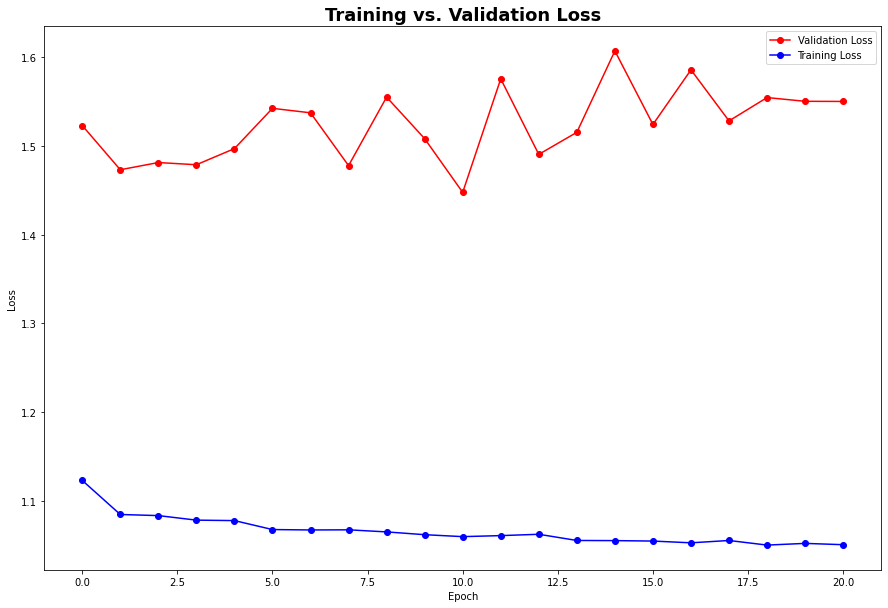

In [100]:
plot_losses(weighted_loss_woAugment_history)

AUC = 0.7424 for Atelectasis
AUC = 0.8570 for Cardiomegaly
AUC = 0.7175 for Consolidation
AUC = 0.8443 for Edema
AUC = 0.8329 for Effusion
AUC = 0.7008 for Emphysema
AUC = 0.6387 for Fibrosis
AUC = 0.7605 for Hernia
AUC = 0.6359 for Infiltration
AUC = 0.6480 for Mass
AUC = 0.5995 for Nodule
AUC = 0.6474 for Pleural_Thickening
AUC = 0.5212 for Pneumonia
AUC = 0.7465 for Pneumothorax


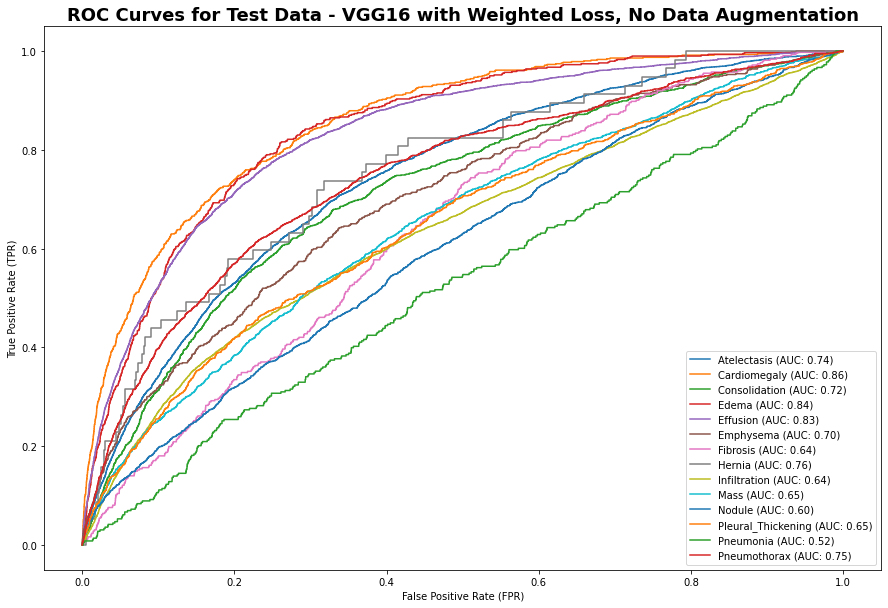

In [101]:
plot_roc_auc(y_pred_weighted_loss_woAugment, test_df, labels, model_name='VGG16 with Weighted Loss, No Data Augmentation')

AUC = 0.2511 for Atelectasis
AUC = 0.1931 for Cardiomegaly
AUC = 0.1001 for Consolidation
AUC = 0.1120 for Edema
AUC = 0.4321 for Effusion
AUC = 0.0683 for Emphysema
AUC = 0.0233 for Fibrosis
AUC = 0.0069 for Hernia
AUC = 0.2883 for Infiltration
AUC = 0.1018 for Mass
AUC = 0.0924 for Nodule
AUC = 0.0634 for Pleural_Thickening
AUC = 0.0140 for Pneumonia
AUC = 0.1456 for Pneumothorax


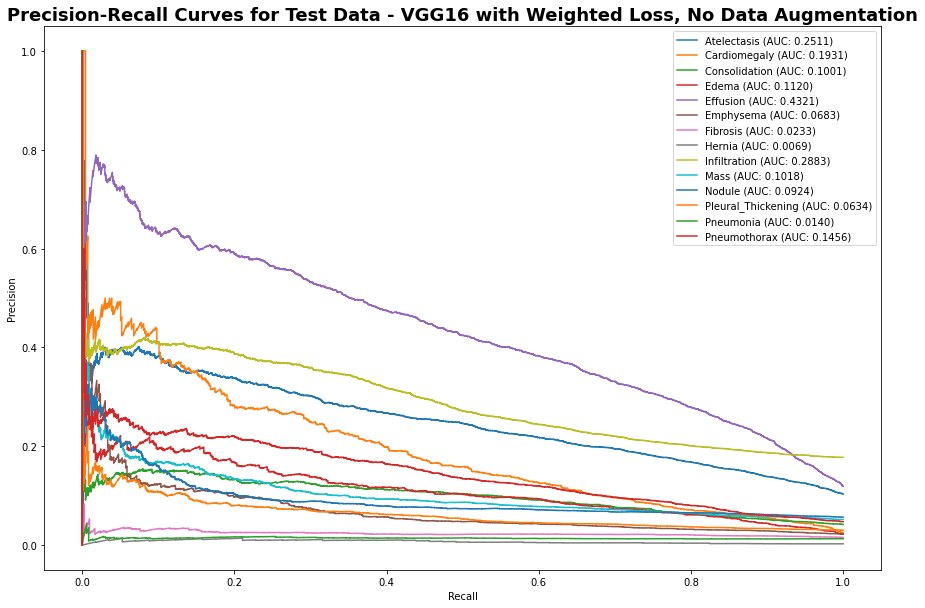

In [102]:
plot_precision_recall_auc(y_pred_weighted_loss_woAugment, test_df, labels, model_name='VGG16 with Weighted Loss, No Data Augmentation')

#### 6. Custom Loss (Interaction Test)
- weighted binary cross entropy loss - positive/negative weighted by their class_weight (from sklearn's compute_class_weight)
- <u>no</u> samplewise normalization + <u>no</u> data randomized augmentation
- no sample or class weights

In [103]:
train_generator, valid_generator, test_generator = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, 
    sample_norm=True, target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb'
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [104]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [105]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg),
    metrics=['accuracy']
)

In [106]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/vgg16-weighted-loss-only.h5'

weighted_loss_only_chkpt = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [107]:
%%time
weighted_loss_only_history = model.fit(
    train_generator, 
    validation_data=valid_generator,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [weighted_loss_only_chkpt, early, reduce_lr]
)

Epoch 1/40


2022-01-11 17:49:31.723904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.1060 - accuracy: 0.2073

2022-01-11 17:55:41.994899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.62274, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/vgg16-weighted-loss-only.h5
250/250 [==============================] - 436s 2s/step - loss: 1.1060 - accuracy: 0.2073 - val_loss: 1.6227 - val_accuracy: 0.2050 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 1.0675 - accuracy: 0.2256
Epoch 00002: val_loss improved from 1.62274 to 1.57560, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/vgg16-weighted-loss-only.h5
250/250 [==============================] - 434s 2s/step - loss: 1.0675 - accuracy: 0.2256 - val_loss: 1.5756 - val_accuracy: 0.1700 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 1.0645 - accuracy: 0.2231
Epoch 00003: val_loss improved from 1.57560 to 1.55773, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/vgg16-weighted-loss-only.h5
250/250 [==============================] - 433s 2s/step - loss: 1.0645 - accurac

In [108]:
y_pred_weighted_loss_only = model.predict(test_generator, batch_size=64, verbose=True)

2022-01-11 19:37:55.577958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 460s 1s/step


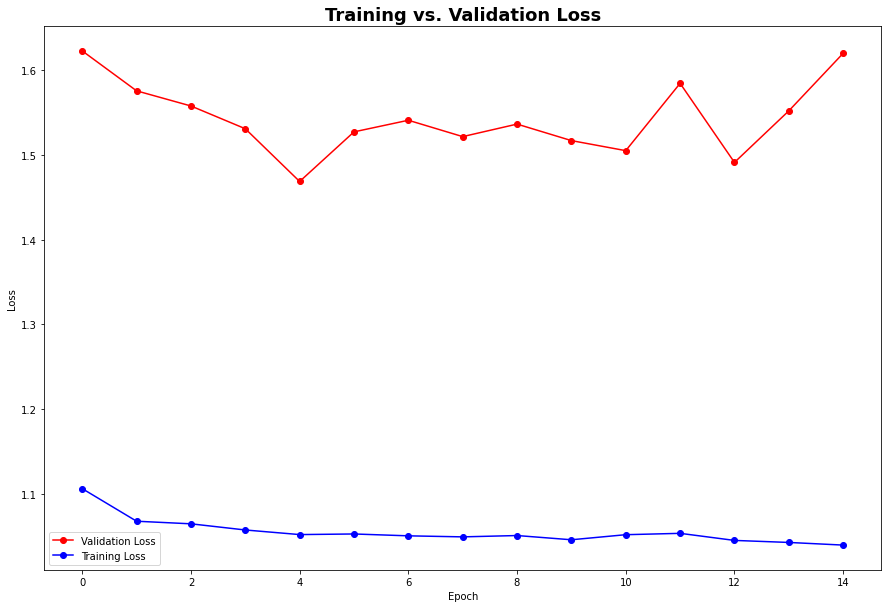

In [109]:
plot_losses(weighted_loss_only_history)

AUC = 0.7402 for Atelectasis
AUC = 0.8647 for Cardiomegaly
AUC = 0.7220 for Consolidation
AUC = 0.8360 for Edema
AUC = 0.8271 for Effusion
AUC = 0.7270 for Emphysema
AUC = 0.6341 for Fibrosis
AUC = 0.7161 for Hernia
AUC = 0.6250 for Infiltration
AUC = 0.6795 for Mass
AUC = 0.6073 for Nodule
AUC = 0.6240 for Pleural_Thickening
AUC = 0.5064 for Pneumonia
AUC = 0.7615 for Pneumothorax


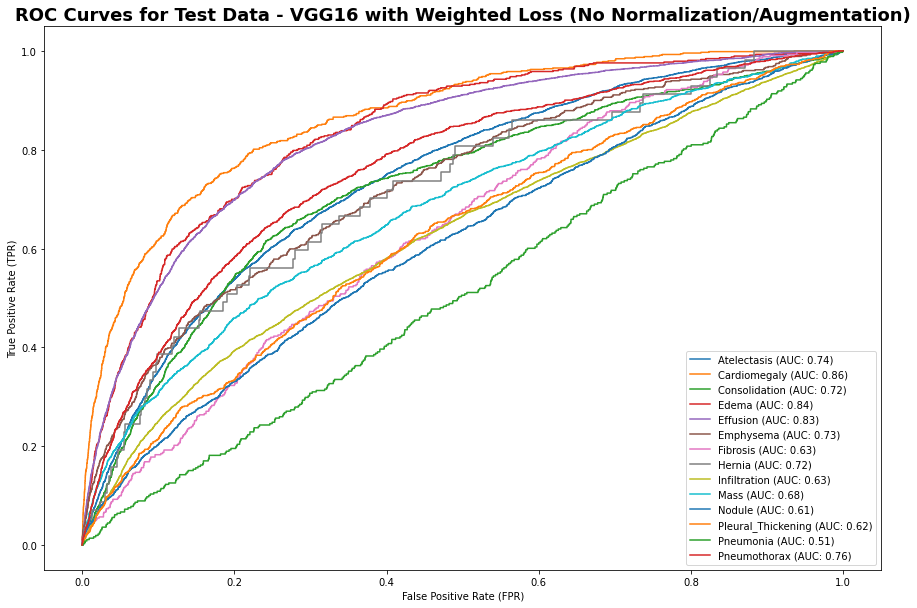

In [110]:
plot_roc_auc(y_pred_weighted_loss_only, test_df, labels, model_name='VGG16 with Weighted Loss (No Normalization/Augmentation)')

AUC = 0.2459 for Atelectasis
AUC = 0.2318 for Cardiomegaly
AUC = 0.1025 for Consolidation
AUC = 0.1187 for Edema
AUC = 0.4230 for Effusion
AUC = 0.0911 for Emphysema
AUC = 0.0315 for Fibrosis
AUC = 0.0058 for Hernia
AUC = 0.2790 for Infiltration
AUC = 0.1278 for Mass
AUC = 0.0945 for Nodule
AUC = 0.0517 for Pleural_Thickening
AUC = 0.0133 for Pneumonia
AUC = 0.1496 for Pneumothorax


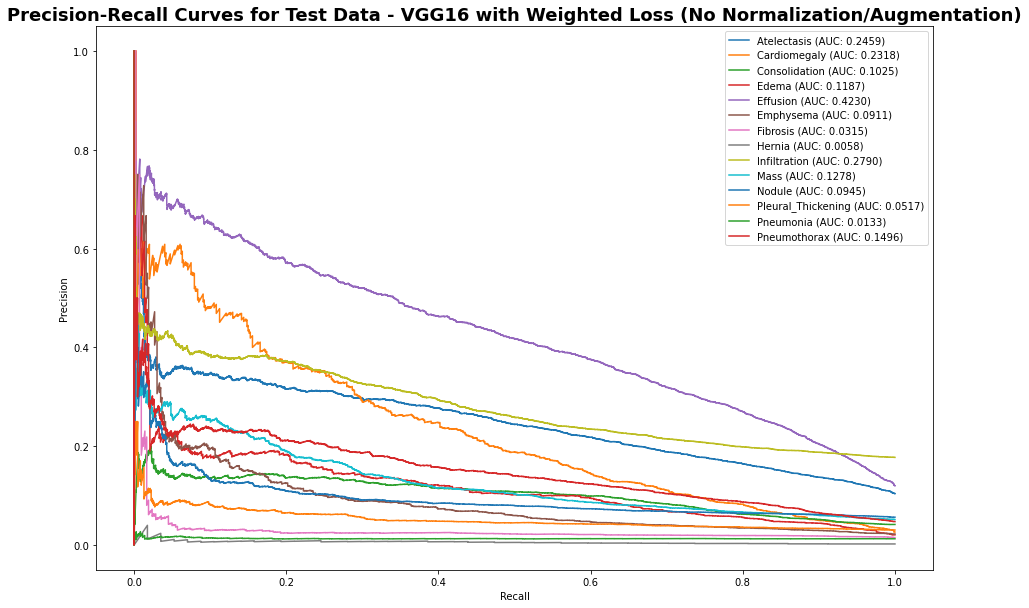

In [111]:
plot_precision_recall_auc(y_pred_weighted_loss_only, test_df, labels, model_name='VGG16 with Weighted Loss (No Normalization/Augmentation)')

#### Store Variables

In [112]:
%store y_pred_base
%store y_pred_sample_weights
%store y_pred_weighted_loss
%store y_pred_weighted_loss_woNorm
%store y_pred_weighted_loss_woAugment
%store y_pred_weighted_loss_only

Stored 'y_pred_base' (ndarray)
Stored 'y_pred_sample_weights' (ndarray)
Stored 'y_pred_weighted_loss' (ndarray)
Stored 'y_pred_weighted_loss_woNorm' (ndarray)
Stored 'y_pred_weighted_loss_woAugment' (ndarray)
Stored 'y_pred_weighted_loss_only' (ndarray)
